## Extracting information from an audio file and creating various graphs based on the data.

In [1]:
# all imported lib

import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import butter, filtfilt

In [2]:
# Load the audio file
audio_path = 'sample1.wav'


y, sr = librosa.load(audio_path)

print(f"Sample Rate : \033[92m{sr} hz\033[0m")
print(f"Audio data :\n \033[92m{y}\033[0m")

# Calculate the duration of the audio in seconds
audio_duration = len(y) / sr
print(f"duration : \033[92m{(audio_duration):.3f} s\033[0m  or {int(audio_duration // 60)} min {(audio_duration % 60):.3f} s")


Sample Rate : 22050 hz
Audio data :
 [0.         0.         0.         ... 0.03269674 0.0326085  0.02392104]
duration : 158.272 s  or 2 min 38.272 s


- Below are different types of graphs representing the same audio data.

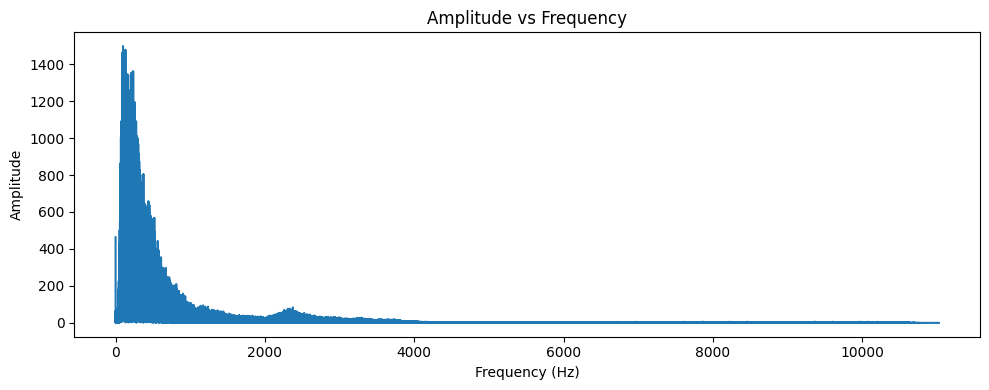

In [3]:

# Compute the magnitude spectrum using FFT
fft = np.fft.fft(y)
magnitude_spectrum = np.abs(fft)
frequency = np.fft.fftfreq(len(y), 1/sr)

# Plot amplitude versus frequency
plt.figure(figsize=(10, 4))
plt.plot(frequency[:len(frequency)//2], magnitude_spectrum[:len(frequency)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Frequency')
plt.tight_layout()
plt.show()

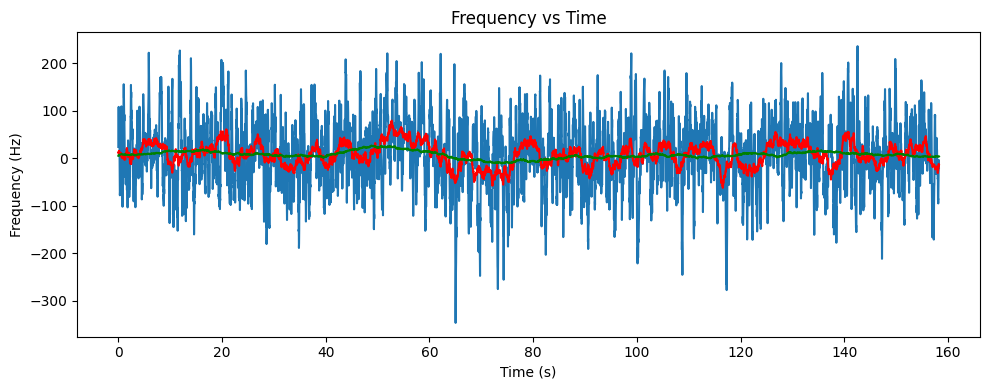

In [4]:
# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)
D_mag, D_phase = librosa.magphase(D)

# Compute the instantaneous frequency
D_freq = np.diff(np.unwrap(np.angle(D_phase))) / (2.0 * np.pi) * sr
freq = np.mean(D_freq, axis=0)

# Compute the time axis
hop_length = 512  # Adjust according to your preference
time = np.arange(D_mag.shape[1]) * hop_length / sr

# Apply moving average filter to smoothen the frequency data
window_size = 10  # Adjust the window size as needed
freq_smooth = np.convolve(freq, np.ones(window_size)/window_size, mode='same')
freq_smooth1 = np.convolve(freq, np.ones(100)/100, mode='same')
freq_smooth2 = np.convolve(freq, np.ones(1000)/1000, mode='same')
# Plot frequency versus time
plt.figure(figsize=(10, 4))
plt.plot(time[:-1], freq_smooth)
plt.plot(time[:-1], freq_smooth1, color='r')
plt.plot(time[:-1], freq_smooth2, color='g')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Time')
plt.tight_layout()
plt.show()

- We're using a moving average filter with three different window sizes to smooth the graph. The blue line closely represents the actual data, the red line provides moderate smoothing to enhance clarity, and the green line is heavily smoothed, intersecting the red line to determine the count of breaths

For above specific graph, this smoothing method using multiple moving average filters isn't the most efficient approach.

The graph below offers significantly more clarity and readability compared to the previous one, making it ideal for accurately counting breaths using the this method.

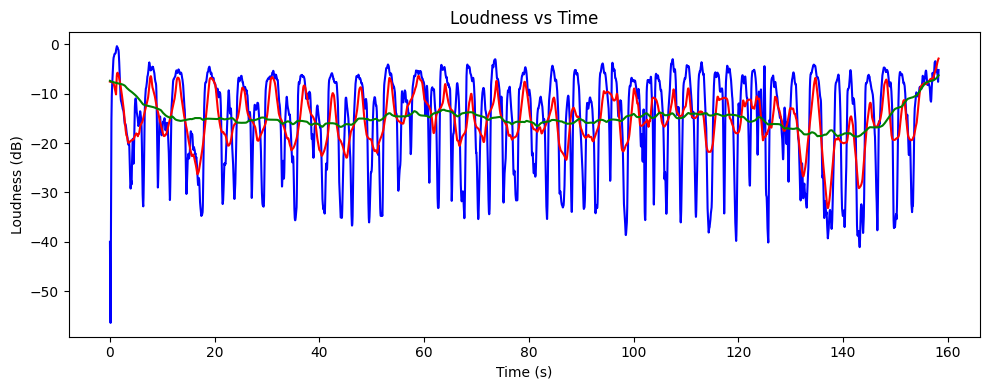

In [5]:
loudness = librosa.amplitude_to_db(librosa.feature.rms(y=y), ref=np.max)

# Apply moving average filter to smoothen the loudness data
window_size = 10  # Adjust the window size as needed
loudness_smooth = np.convolve(loudness.squeeze(), np.ones(window_size)/window_size, mode='same')
loudness_smooth1 = np.convolve(loudness.squeeze(), np.ones(100)/100, mode='same')
loudness_smooth2 = np.convolve(loudness.squeeze(), np.ones(1000)/1000, mode='same')

# Compute the time axis for plotting
time = librosa.times_like(loudness)

# Plot loudness over time
plt.figure(figsize=(10, 4))
# librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(time, loudness_smooth, color='b')
plt.plot(time, loudness_smooth1, color='r')
plt.plot(time, loudness_smooth2, color='g')
plt.xlabel('Time (s)')
plt.ylabel('Loudness (dB)')
plt.title('Loudness vs Time')
plt.tight_layout()
plt.show()

##### Calculating Breathing Rate using above graph 

In [6]:
count = 0
for i in range(1,len(time)):
    if ((loudness_smooth1[i-1] > loudness_smooth2[i-1] and loudness_smooth1[i] < loudness_smooth2[i]) or 
        (loudness_smooth1[i-1] < loudness_smooth2[i-1] and loudness_smooth1[i] > loudness_smooth2[i])):
        count += 1
print("number of intersection: ", count)
print("Total Breath count:", count/2)
print(f"Breathing rate : \033[92m{(((count/2)/audio_duration)*60):.2f} Breath/min\033[0m ")

number of intersection:  65
Total Breath count: 32.5
Breathing rate : 12.32 Breath/min 


The **spectrogram** below, displaying frequency, time, and magnitude, provides a comprehensive visualization and **I think this is ideal for analyzing audio data**. Its depiction of all three dimensions simultaneously offers a clear and detailed view, making it well-suited for tasks such as determining breath rate or extracting other relevant information from the audio.


Though I still need to understand how to effectively utilize this graph to obtain accurate data.

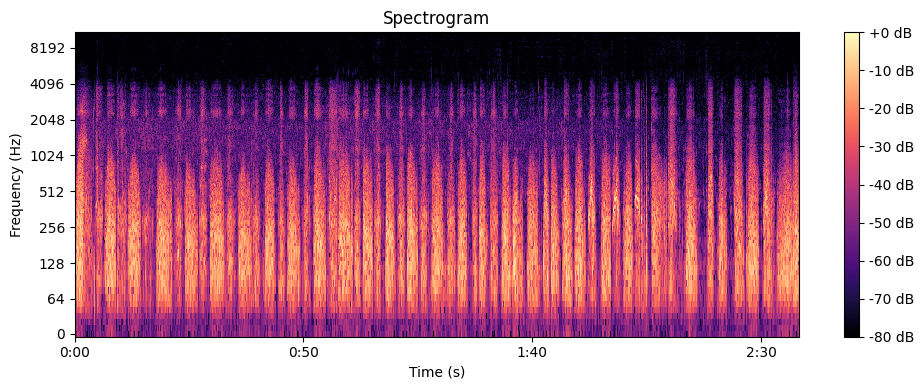

In [7]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

** When analyzing clean audio data, the process is straightforward. However, if there is noise or disturbances in the audio, various filters need to be applied for effective analysis.

After using a high pass filter

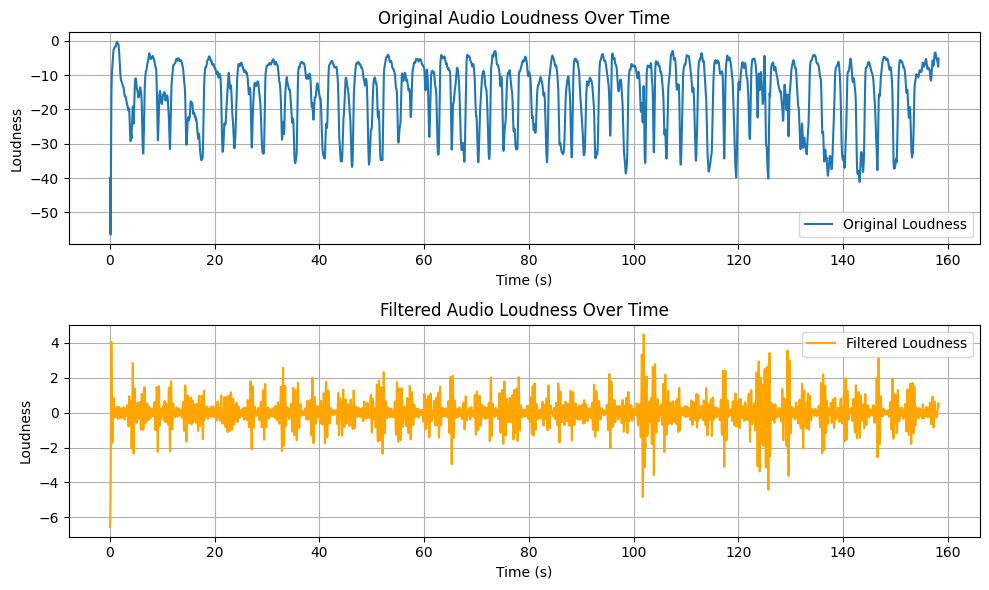

In [8]:

# Design Butterworth high-pass filter
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


loudness = librosa.amplitude_to_db(librosa.feature.rms(y=y), ref=np.max)
window_size = 10  # Adjust the window size as needed
loudness_smooth = np.convolve(loudness.squeeze(), np.ones(window_size)/window_size, mode='same')
# Compute the time axis for plotting
time = librosa.times_like(loudness)

# Set filter parameters
cutoff_freq = 1000  # 1000 Hz
order = 5

# Apply Butterworth high-pass filter
filtered_loudness = butter_highpass_filter(loudness, cutoff_freq, sr, order=order)
filtered_loudness_smooth1 = np.convolve(filtered_loudness.squeeze(), np.ones(10)/10, mode='same')

# Plot original and filtered loudness over time
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, loudness_smooth, label='Original Loudness')
plt.title('Original Audio Loudness Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Loudness')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, filtered_loudness_smooth1, label='Filtered Loudness', color='orange')
plt.title('Filtered Audio Loudness Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Loudness')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
